#Library Import

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Importing the dataset data from drive (Project2/Project 1 Data) Data then i have Train_data,Test_data and in train data i have 5 folders for 5 classes A,B,C,D,E and file names there are 1_A.jpg , 2_A.jpg etc

# In test data i have files named 1.jpg,2.jpg etc

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torch.optim as optim
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Simple CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 37 * 50, 512)
        self.fc2 = nn.Linear(512, 5)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output
        x = x.view(-1, 128 * 37 * 50)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x



x = self.dropout(x)

Dropout randomly sets a fraction of the neurons (here, 50%) to 0 during training.

Purpose: prevent overfitting by making the network not rely too much on any single neuron.

Effect: the network learns more robust features that generalize better.

In [ ]:
# Create an instance of the model
model = CNN()

# Print model summary
print(model)

# Example input tensor
input_tensor = torch.randn(1, 1, 300, 400) #(batch_size, channels, height, width)

# Get output
output = model(input_tensor)

print(f"Output shape: {output.shape}")


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=236800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Output shape: torch.Size([1, 5])


##Image transform

In [ ]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# ----------------------------
# Dataset Classes
# ----------------------------
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()
        print(f"Loaded {len(self.images)} images from {root_dir}")  # Debug line
        print(f"Classes found: {self.classes}")  # Debug line

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                    images.append((os.path.join(class_dir, img_name), self.class_to_idx[cls]))# mapping each image to its class label
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
        self.images.sort()
        print(f"Loaded {len(self.images)} test images from {root_dir}")  # Debug line

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, img_name

# ----------------------------
# Transforms
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((300, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ----------------------------
# Paths
# ----------------------------
base_dir = Path("/content/drive/MyDrive/Project2/Project 1 Data")
train_dir = os.path.join(base_dir, 'Train_Data')
test_dir = os.path.join(base_dir, 'Test_Data')

# Verify directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found: {test_dir}")

# ----------------------------
# Datasets
# ----------------------------
train_dataset = CustomImageDataset(train_dir, transform=transform)
test_dataset = TestImageDataset(test_dir, transform=transform)

# ----------------------------
# Split train dataset
# ----------------------------
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
print(f"Train size: {train_size}, Validation size: {val_size}")  # Debug line

if train_size <= 0 or val_size <= 0:
    raise ValueError("Dataset is empty or too small after splitting. Check the Train_Data directory.")

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# ----------------------------
# DataLoaders
# ----------------------------

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ----------------------------
# Info
# ----------------------------
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")
print(f"Classes: {train_dataset.dataset.classes}")

# Example of iterating through the train_loader
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Loaded 2516 images from /content/drive/MyDrive/Project2/Project 1 Data/Train_Data
Classes found: ['A', 'B', 'C', 'D', 'S']
Loaded 478 test images from /content/drive/MyDrive/Project2/Project 1 Data/Test_Data
Train size: 2264, Validation size: 252
Number of training samples: 2264
Number of validation samples: 252
Number of test samples: 478
Number of classes: 5
Classes: ['A', 'B', 'C', 'D', 'S']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([32, 1, 300, 400])
Labels shape: torch.Size([32])


DataLoader is a PyTorch class that wraps a Dataset and allows you to load data in batches, shuffle it, and load it in parallel

| Argument        | Meaning                                                                                                            |
| --------------- | ------------------------------------------------------------------------------------------------------------------ |
| `train_dataset` | The dataset object to load data from. In your case, `CustomImageDataset` or a `Subset` of it after `random_split`. |
| `batch_size=32` | Number of samples per batch. So each iteration gives **32 images + 32 labels**.                                    |
| `shuffle=True`  | Randomly shuffle the dataset at the start of each epoch. Helps avoid model overfitting due to order of data.       |
| `num_workers=4` | Number of subprocesses to use for loading data. Increases speed by parallel loading.                               |


In [ ]:
print(train_dataset[0])
print(val_dataset[200])
print(test_dataset[2])

(tensor([[[ 0.2314,  0.2314,  0.2314,  ...,  0.2078,  0.2078,  0.2078],
         [ 0.2314,  0.2314,  0.2314,  ...,  0.2078,  0.2078,  0.2078],
         [ 0.2314,  0.2314,  0.2314,  ...,  0.2078,  0.2078,  0.2078],
         ...,
         [-0.5922, -0.5922, -0.5843,  ..., -0.8902, -0.8745, -0.8745],
         [-0.6078, -0.6000, -0.6000,  ..., -0.8510, -0.8431, -0.8353],
         [-0.6157, -0.6078, -0.6078,  ..., -0.8039, -0.7882, -0.7725]]]), 0)
(tensor([[[ 0.0510,  0.0510,  0.0510,  ...,  0.1294,  0.1294,  0.1294],
         [ 0.0510,  0.0510,  0.0510,  ...,  0.1294,  0.1294,  0.1294],
         [ 0.0510,  0.0510,  0.0510,  ...,  0.1294,  0.1294,  0.1294],
         ...,
         [ 0.8196,  0.8510,  0.8588,  ..., -0.7961, -0.8196, -0.8353],
         [ 0.4980,  0.5059,  0.4824,  ..., -0.7961, -0.8196, -0.8353],
         [ 0.1529,  0.1451,  0.1137,  ..., -0.7961, -0.8196, -0.8353]]]), 2)
(tensor([[[ 0.3647,  0.3647,  0.3647,  ...,  0.7176,  0.7176,  0.7098],
         [ 0.3647,  0.3647,  0.364

| Dataset         | Labels? | Use case                      |
| --------------- | ------- | ----------------------------- |
| `train_dataset` | Yes     | Training                      |
| `val_dataset`   | Yes     | Validation during training    |
| `test_dataset`  | No      | Model inference / predictions |


##CNN Training

In [ ]:

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

# Train the model
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')
print("Training complete. Model saved as 'cnn_model.pth'")

Epoch [1/20], Train Loss: 1.9452, Val Loss: 1.5096, Val Accuracy: 34.13%, Time: 103.35s
Epoch [2/20], Train Loss: 1.4668, Val Loss: 1.4529, Val Accuracy: 35.71%, Time: 14.43s
Epoch [3/20], Train Loss: 1.4216, Val Loss: 1.4112, Val Accuracy: 39.29%, Time: 14.42s
Epoch [4/20], Train Loss: 1.3854, Val Loss: 1.4186, Val Accuracy: 42.46%, Time: 14.35s
Epoch [5/20], Train Loss: 1.3774, Val Loss: 1.4071, Val Accuracy: 36.51%, Time: 14.53s
Epoch [6/20], Train Loss: 1.3224, Val Loss: 1.3876, Val Accuracy: 40.08%, Time: 14.02s
Epoch [7/20], Train Loss: 1.2139, Val Loss: 1.4869, Val Accuracy: 42.86%, Time: 14.01s
Epoch [8/20], Train Loss: 0.9847, Val Loss: 1.5858, Val Accuracy: 32.94%, Time: 13.99s
Epoch [9/20], Train Loss: 0.7263, Val Loss: 1.8698, Val Accuracy: 38.10%, Time: 14.02s
Epoch [10/20], Train Loss: 0.4675, Val Loss: 2.1872, Val Accuracy: 38.89%, Time: 13.98s
Epoch [11/20], Train Loss: 0.2737, Val Loss: 2.8447, Val Accuracy: 36.11%, Time: 13.93s
Epoch [12/20], Train Loss: 0.2098, Val L

After 20 epoch the best accuracy achieved is 42.86%

#Confusion Matrix

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


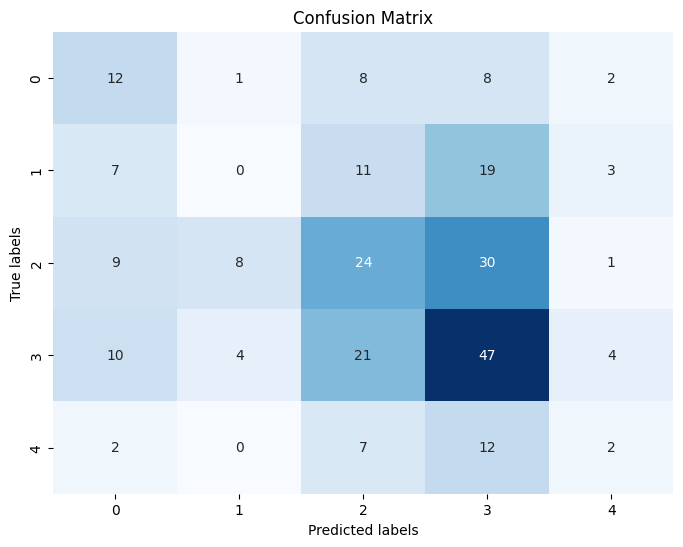

In [ ]:
# plot confusion matrix for above cnn model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Load the trained model
model = CNN()
model.load_state_dict(torch.load('cnn_model.pth'))
model.to(device)

# Plot confusion matrix for the validation set
plot_confusion_matrix(model, val_loader)



#Improved CNN

Sure! Let’s break down the CNN architecture you provided layer by layer. Your model has **3 convolutional blocks** followed by a fully connected classifier. I’ll also compute the output dimensions step by step (assuming the input is a **grayscale image of size 300×400**, because the classifier expects `128*37*50` features):

---

### **Input**

* Shape: `(1, H, W)` → `(1, 300, 400)`
* 1 channel (grayscale)

---

### **Feature Extractor (Convolutional Layers)**

#### **Block 1**

1. `Conv2d(1, 32, kernel_size=3, stride=1, padding=1)`

   * Output: `(32, 300, 400)`
     (Padding=1 keeps spatial size same)

2. `BatchNorm2d(32)` → `(32, 300, 400)`

3. `ReLU()` → `(32, 300, 400)`

4. `MaxPool2d(kernel_size=2, stride=2)`

   * Output: `(32, 150, 200)`

5. `Dropout2d(0.25)` → `(32, 150, 200)`

---

#### **Block 2**

1. `Conv2d(32, 64, kernel_size=3, stride=1, padding=1)` → `(64, 150, 200)`

2. `BatchNorm2d(64)` → `(64, 150, 200)`

3. `ReLU()` → `(64, 150, 200)`

4. `MaxPool2d(2,2)` → `(64, 75, 100)`

5. `Dropout2d(0.25)` → `(64, 75, 100)`

---

#### **Block 3**

1. `Conv2d(64, 128, kernel_size=3, stride=1, padding=1)` → `(128, 75, 100)`

2. `BatchNorm2d(128)` → `(128, 75, 100)`

3. `ReLU()` → `(128, 75, 100)`

4. `MaxPool2d(2,2)` → `(128, 37, 50)`
   (This matches the flattened size used in the classifier: `128*37*50 = 236,800`)

5. `Dropout2d(0.25)` → `(128, 37, 50)`

---

### **Classifier (Fully Connected Layers)**

1. Flatten → `(128*37*50) = 236,800` features

2. `Linear(236,800 → 512)` → `(512)`

3. `BatchNorm1d(512)` → `(512)`

4. `ReLU()` → `(512)`

5. `Dropout(0.5)` → `(512)`

6. `Linear(512 → 5)` → `(5)`

   * Output: logits for **5 classes**

---

### ✅ **Summary Table**

| Layer       | Type               | Output Shape   |
| ----------- | ------------------ | -------------- |
| Input       | -                  | (1, 300, 400)  |
| Conv1       | Conv2d 1→32        | (32, 300, 400) |
| BN1         | BatchNorm2d        | (32, 300, 400) |
| ReLU1       | ReLU               | (32, 300, 400) |
| MaxPool1    | MaxPool2d 2x2      | (32, 150, 200) |
| Dropout1    | Dropout2d 0.25     | (32, 150, 200) |
| Conv2       | Conv2d 32→64       | (64, 150, 200) |
| BN2         | BatchNorm2d        | (64, 150, 200) |
| ReLU2       | ReLU               | (64, 150, 200) |
| MaxPool2    | MaxPool2d 2x2      | (64, 75, 100)  |
| Dropout2    | Dropout2d 0.25     | (64, 75, 100)  |
| Conv3       | Conv2d 64→128      | (128, 75, 100) |
| BN3         | BatchNorm2d        | (128, 75, 100) |
| ReLU3       | ReLU               | (128, 75, 100) |
| MaxPool3    | MaxPool2d 2x2      | (128, 37, 50)  |
| Dropout3    | Dropout2d 0.25     | (128, 37, 50)  |
| Flatten     | -                  | (236,800)      |
| FC1         | Linear 236,800→512 | (512)          |
| BN\_fc      | BatchNorm1d        | (512)          |
| ReLU\_fc    | ReLU               | (512)          |
| Dropout\_fc | Dropout 0.5        | (512)          |
| FC2         | Linear 512→5       | (5)            |

---



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import time

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 37 * 50, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Update your datasets with these transforms
train_dataset.dataset.transform = train_transform
val_dataset.transform = val_transform

# Re-create data loaders with the updated datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

# Train the model
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the trained model
torch.save(model.state_dict(), 'cnn_model_improved.pth')
print("Training complete. Model saved as 'cnn_model_improved.pth'")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Train Loss: 1.6100, Val Loss: 1.4225, Val Accuracy: 38.89%, Time: 20.24s
Epoch [2/20], Train Loss: 1.4725, Val Loss: 1.4094, Val Accuracy: 43.25%, Time: 19.06s
Epoch [3/20], Train Loss: 1.4342, Val Loss: 1.3929, Val Accuracy: 36.90%, Time: 18.45s
Epoch [4/20], Train Loss: 1.4189, Val Loss: 1.3887, Val Accuracy: 39.29%, Time: 19.31s
Epoch [5/20], Train Loss: 1.4242, Val Loss: 1.4154, Val Accuracy: 35.71%, Time: 19.13s
Epoch [6/20], Train Loss: 1.4086, Val Loss: 1.3911, Val Accuracy: 36.11%, Time: 18.51s
Epoch [7/20], Train Loss: 1.4069, Val Loss: 1.3720, Val Accuracy: 40.87%, Time: 19.48s
Epoch [8/20], Train Loss: 1.3904, Val Loss: 1.3787, Val Accuracy: 40.48%, Time: 18.61s
Epoch [9/20], Train Loss: 1.3722, Val Loss: 1.3718, Val Accuracy: 41.27%, Time: 18.42s
Epoch [10/20], Train Loss: 1.3949, Val Loss: 1.3617, Val Accuracy: 42.06%, Time: 19.84s
Epoch [11/20], Train Loss: 1.3857, Val Loss: 1.3543, Val Accuracy: 42.06%, Time: 18.41s
Epoch [12/20], Train Loss: 1.3759, Val Lo

| Stage   | Layer                                  | Output Shape      |
| ------- | -------------------------------------- | ----------------- |
| Input   | -                                      | `(1, H, W)`       |
| Conv1   | Conv2d(1,32)+BN+ReLU+MaxPool+Dropout   | `(32, H/2, W/2)`  |
| Conv2   | Conv2d(32,64)+BN+ReLU+MaxPool+Dropout  | `(64, H/4, W/4)`  |
| Conv3   | Conv2d(64,128)+BN+ReLU+MaxPool+Dropout | `(128, H/8, W/8)` |
| Flatten | -                                      | `(128*H/8*W/8)`   |
| FC1     | Linear+BN+ReLU+Dropout                 | `(512)`           |
| FC2     | Linear                                 | `(5)`             |


The accuracy has increased by not to large extent. It has increased by roughly  and the best accuracy achieved is 43.25%

##Confusion matrix

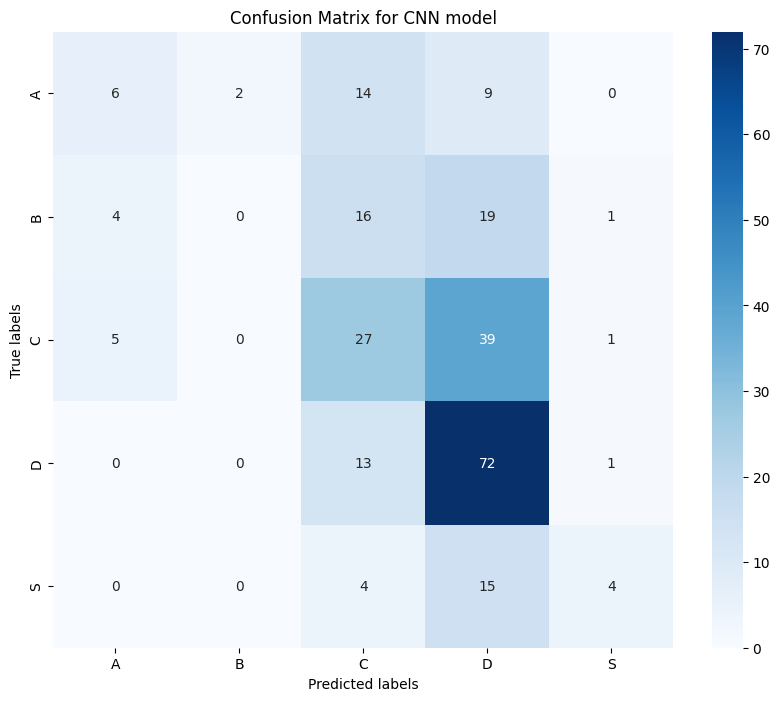

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

def plot_confusion_matrix(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert numeric labels to letter labels
    label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'S'}
    y_true = [label_map[y] for y in y_true]
    y_pred = [label_map[y] for y in y_pred]

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C', 'D', 'S'])

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['A', 'B', 'C', 'D', 'S'],
                yticklabels=['A', 'B', 'C', 'D', 'S'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for CNN model')
    plt.show()

# Load the trained model
model = CNN()
model.load_state_dict(torch.load('cnn_model_improved.pth'))
model.to(device)

# Plot confusion matrix for the validation set
plot_confusion_matrix(model, val_loader, device)

#Loss

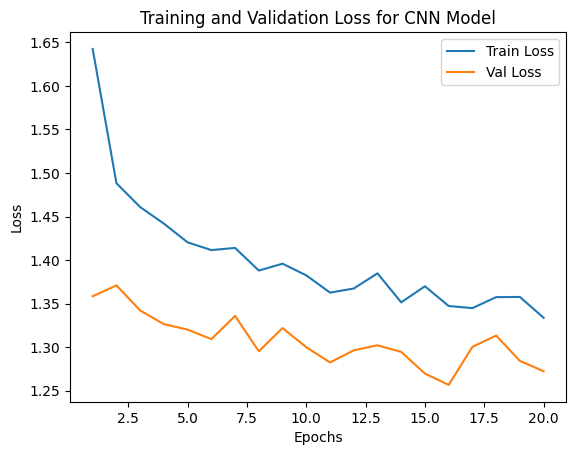

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 21))
# Training loss per epoch
train_loss = [1.6425, 1.4883, 1.4609, 1.4419, 1.4204, 1.4115, 1.4140, 1.3880, 1.3959, 1.3825, 1.3627, 1.3674, 1.3848, 1.3515, 1.3700, 1.3473, 1.3449, 1.3575, 1.3577, 1.3338]

# Validation loss per epoch
val_loss = [1.3585, 1.3710, 1.3422, 1.3265, 1.3202, 1.3093, 1.3359, 1.2953, 1.3220, 1.3000,1.2825, 1.2964, 1.3022, 1.2946, 1.2697, 1.2567, 1.3004, 1.3134, 1.2843, 1.2724]

# val_accuracy= [40.48, 42.86, 43.65, 38.89, 40.48, 43.65, 44.44, 50.79, 47.62, 41.27, 42.86, 43.65, 51.59, 41.27, 45.24, 44.44, 50.79, 44.44, 47.62, 45.24, 42.86, 52.38, 41.27, 49.21, 49.21, 46.83, 50.00, 42.06, 46.83, 48.41, 48.41, 48.41, 42.06, 47.62, 50.79, 49.21, 50.79, 50.00, 49.21, 46.83, 46.03, 50.79, 48.41, 46.83, 46.03, 52.38, 51.59, 46.03, 45.24, 46.03]
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for CNN Model')
plt.show()

#Accuracy

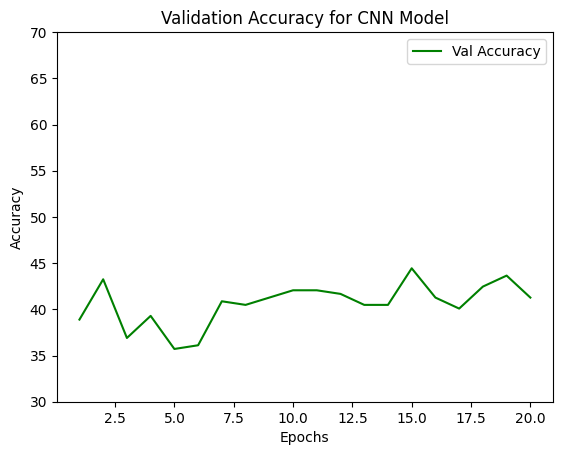

In [2]:
# plot for val accuracy
import matplotlib.pyplot as plt
val_accuracy = [
    38.89,  # Epoch 1
    43.25,  # Epoch 2
    36.90,  # Epoch 3
    39.29,  # Epoch 4
    35.71,  # Epoch 5
    36.11,  # Epoch 6
    40.87,  # Epoch 7
    40.48,  # Epoch 8
    41.27,  # Epoch 9
    42.06,  # Epoch 10
    42.06,  # Epoch 11
    41.67,  # Epoch 12
    40.48,  # Epoch 13
    40.48,  # Epoch 14
    44.44,  # Epoch 15
    41.27,  # Epoch 16
    40.08,  # Epoch 17
    42.46,  # Epoch 18
    43.65,  # Epoch 19
    41.27   # Epoch 20
]
epochs=[]
for i in range(20):
  epochs.append(i+1)
plt.plot(epochs, val_accuracy, label='Val Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for CNN Model')
plt.ylim(30, 70)
plt.show()

#Save prediction

In [ ]:
# make a csv file to submit it should have 2 columns , ID and Predictions where predictions from 1 to 5 are A,B,C,D,E respectively and ID is the name of the file from test data

# Load the model
model = CNN().to(device)
model.load_state_dict(torch.load('cnn_model_improved.pth'))
model.eval()

# Make predictions
predictions = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(zip(img_names, predicted.cpu().numpy()))

# Save predictions to a CSV file
df = pd.DataFrame(predictions, columns=['ID', 'Predictions'])
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Predictions saved to 'predictions.csv'


In [ ]:
df.head()

,ID,Predictions
0,1.jpg,3
1,10.jpg,2
2,100.jpg,3
3,101.jpg,2
4,102.jpg,3


In [ ]:
# give the predictions in this format and save it as predictions.csv

# Load the predictions
df = pd.read_csv('predictions.csv')

# remove the jpg extension from the ID column and sort by ID
df['ID'] = df['ID'].str.replace('.jpg', '').astype(int)
df = df.sort_values('ID').reset_index(drop=True)

# now save the sorted predictions
df.to_csv('predictions.csv', index=False)
print("Predictions sorted and saved to 'predictions.csv'")

Predictions sorted and saved to 'predictions.csv'


In [ ]:
# predictions are from 0 to 4 so we need to add 1 to each prediction
df['Predictions'] += 1

# Save the final predictions
df.to_csv('predictions.csv', index=False)
print("Final predictions saved to 'predictions.csv'")

Final predictions saved to 'predictions.csv'


##New Library Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
import os
from PIL import Image
import random
import csv

#Transformations on image

In [ ]:
# Basic transformations for all images
basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
                         std=[0.229, 0.224, 0.225]),
])

# Augmentation transformations to create additional samples
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
])


In [ ]:
# Path to your training data
train_data_path = base_dir = Path("/content/drive/MyDrive/Project2/Project 1 Data/Train_Data")

# Verify that the training data path exists
if not os.path.isdir(train_data_path):
    raise FileNotFoundError(f"Training data directory not found at {train_data_path}")

# Load the full training dataset without any transformations initially
full_train_dataset = ImageFolder(root=train_data_path, transform=None)

# Extract labels for stratified splitting
labels = [label for _, label in full_train_dataset.samples]


In [ ]:
# Define the split: 80% training and 20% validation
split_ratio = 0.2
split = StratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=42)
train_idx, val_idx = next(split.split(np.zeros(len(labels)), labels))

# Create training and validation subsets
train_subset = Subset(full_train_dataset, train_idx)
val_subset = Subset(full_train_dataset, val_idx)


#Class Counts

In [ ]:
# Function to compute class counts
def get_class_counts(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Get class counts for the training subset
train_class_counts = get_class_counts(train_subset)
print("Class Counts in Training Set:", train_class_counts)

# Determine the maximum class count
max_count = max(train_class_counts.values())
print("Maximum class count:", max_count)

# Determine the number of samples to generate for each class
augmentation_counts = {cls: max_count - count for cls, count in train_class_counts.items()}
print("Number of Augmented Samples Needed per Class:", augmentation_counts)


Class Counts in Training Set: {4: 168, 3: 731, 1: 289, 0: 239, 2: 585}
Maximum class count: 731
Number of Augmented Samples Needed per Class: {4: 563, 3: 0, 1: 442, 0: 492, 2: 146}


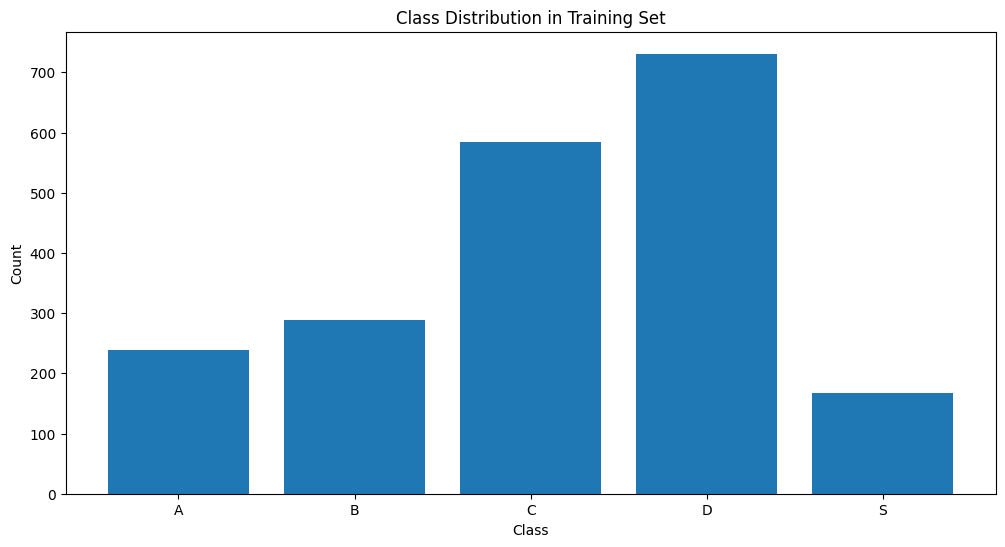

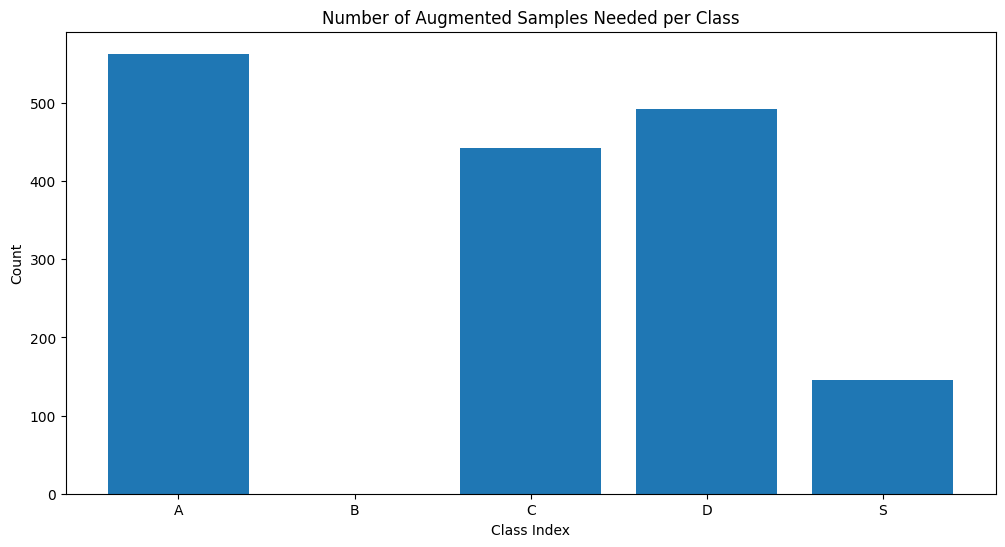

In [ ]:
# plot the class distribution and the number of augmented samples needed
import matplotlib.pyplot as plt

# Sort the class counts by class index
sorted_counts = {cls: train_class_counts[cls] for cls in sorted(train_class_counts.keys
())}
# get the class names from the dataset
class_names = full_train_dataset.classes

# Plot the class distribution by class name not by class index
plt.figure(figsize=(12, 6))
plt.bar(class_names, sorted_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()#Class Counts in Training Set: {4: 168, 3: 731, 1: 289, 0: 239, 2: 585}

# Plot the number of augmented samples needed by class index
plt.figure(figsize=(12, 6))
plt.bar(class_names, augmentation_counts.values())
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.title('Number of Augmented Samples Needed per Class')
plt.show()

#Balancing the dataset

In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, augmentation_counts, augment_transform, basic_transform):
        """
        original_dataset: Subset of ImageFolder
        augmentation_counts: dict mapping class index to number of samples to augment
        augment_transform: Transformations to apply for augmentation
        basic_transform: Basic transformations to apply to all images
        """
        self.original_dataset = original_dataset
        self.augmentation_counts = augmentation_counts
        self.augment_transform = augment_transform
        self.basic_transform = basic_transform

        # Organize indices by class
        self.class_to_indices = {}
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

        # Prepare lists of original and augmented samples
        self.samples = []
        for label, count in augmentation_counts.items():
            original_indices = self.class_to_indices[label]
            self.samples.extend(original_indices)  # Original samples

            # Generate augmented samples
            for _ in range(count):
                original_idx = random.choice(original_indices)
                self.samples.append(original_idx)  # Placeholder for augmented samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        original_idx = self.samples[idx]
        image, label = self.original_dataset[original_idx]

        # Check if this index is for an augmented sample
        # Since we appended original indices first, the augmented samples are after
        if original_idx in self.class_to_indices[label] and self.samples.count(original_idx) > 1:
            # Apply augmentation
            image = self.augment_transform(image)
        else:
            # Apply basic transform
            image = self.basic_transform(image)

        return image, label


In [ ]:
# Initialize the balanced dataset
balanced_train_dataset = BalancedDataset(
    original_dataset=train_subset,
    augmentation_counts=augmentation_counts,
    augment_transform=augment_transform,
    basic_transform=basic_transform
)

# Verify the new class counts
def verify_balanced(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

balanced_train_class_counts = verify_balanced(balanced_train_dataset)
print("Class Counts in Balanced Training Set:", balanced_train_class_counts)


Class Counts in Balanced Training Set: {4: 731, 3: 731, 1: 731, 0: 731, 2: 731}


Purpose of the Code

The goal of this code is to balance the training dataset by augmenting underrepresented classes. In other words:

If some classes have fewer images than others, we create more samples for those classes using augmentation.

The dataset will still include the original images, but some images will be repeated with transformations applied to increase class balance.

Summary of What Happens

Original dataset is split by class indices.

For each class, original samples are included.

Additional samples are added according to augmentation_counts:

These are indices repeated for augmentation.

In __getitem__, repeated indices are augmented using augment_transform.

verify_balanced checks the final number of samples per class.

Effectively:

Classes with fewer original images are augmented to balance the dataset.

Classes with enough images are mostly unchanged.

The dataset can now be used in a DataLoader for balanced training.

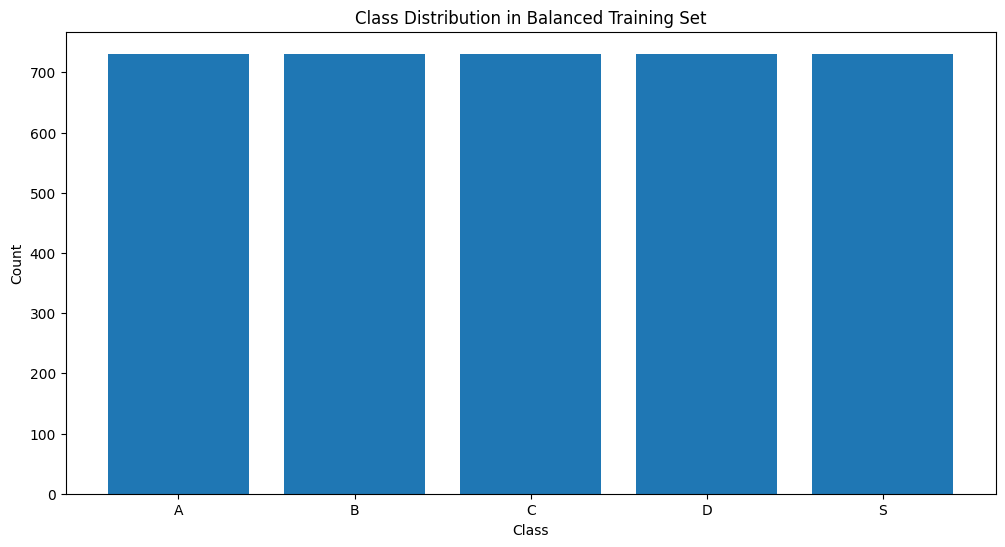

In [ ]:
# plot the class distribution of the balanced dataset
# Sort the class counts by class index
sorted_counts = {cls: balanced_train_class_counts[cls] for cls in sorted(balanced_train_class_counts.keys
())}
# get the class names from the dataset
class_names = full_train_dataset.classes

# Plot the class distribution by class name not by class index
plt.figure(figsize=(12, 6))
plt.bar(class_names, sorted_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Balanced Training Set')
plt.show()

#New dataset

In [ ]:
# Define a new Dataset class to apply transforms to validation subset
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        image = self.transform(image)
        return image, label

# Apply basic_transform to validation dataset
balanced_val_dataset = SubsetWithTransform(val_subset, basic_transform)

In [ ]:
# Define DataLoaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(balanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Summary

SubsetWithTransform is used to apply transforms to a subset, here the validation data.

balanced_val_dataset applies basic preprocessing to validation images.

DataLoaders wrap both datasets:

Training loader → augmented, shuffled batches.

Validation loader → preprocessed, ordered batches.

#Training Vision transformer base model

In [ ]:
# Number of classes
num_classes = 5

# Initialize the pre-trained ViT model
# You can choose different ViT variants like 'vit_base_patch16_224', 'vit_large_patch16_224', etc.
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classification head to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

# Move the model to the appropriate device
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)


In [ ]:
# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_accuracy = 0.0
    best_model_path = 'best_vit_model.pth'

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

        # Step the scheduler
        scheduler.step()

        # Save the model if it has the best accuracy so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with Val Accuracy: {best_val_accuracy:.2f}%")

    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.2f}%")
    print(f"Best model saved as '{best_model_path}'.")


##VIT BASE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
import os
from PIL import Image
import random
import csv
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

# ----------------------------
# 1. Device Configuration
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Data Augmentation and Normalization
# ----------------------------

# Basic transformations for all images
basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
                         std=[0.229, 0.224, 0.225]),
])

# Augmentation transformations to create additional samples
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
])

# ----------------------------
# 3. Load and Split the Dataset
# ----------------------------

# Paths
# ----------------------------
base_dir = Path("/content/drive/MyDrive/Project2/Project 1 Data")
train_data_path = os.path.join(base_dir, 'Train_Data')


# Verify that the training data path exists
if not os.path.isdir(train_data_path):
    raise FileNotFoundError(f"Training data directory not found at {train_data_path}")

# Load the full training dataset without any transformations initially
full_train_dataset = ImageFolder(root=train_data_path, transform=None)

# Extract labels for stratified splitting
labels = [label for _, label in full_train_dataset.samples]

# Define the split: 80% training and 20% validation
split_ratio = 0.2
split = StratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=42)
train_idx, val_idx = next(split.split(np.zeros(len(labels)), labels))

# Create training and validation subsets
train_subset = Subset(full_train_dataset, train_idx)
val_subset = Subset(full_train_dataset, val_idx)

# ----------------------------
# 4. Identify and Balance the Dataset
# ----------------------------

# Function to compute class counts
def get_class_counts(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Get class counts for the training subset
train_class_counts = get_class_counts(train_subset)
print("Class Counts in Training Set:", train_class_counts)

# Determine the maximum class count
max_count = max(train_class_counts.values())
print("Maximum class count:", max_count)

# Determine the number of samples to generate for each class
augmentation_counts = {cls: max_count - count for cls, count in train_class_counts.items()}
print("Number of Augmented Samples Needed per Class:", augmentation_counts)

# Custom BalancedDataset
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, augmentation_counts, augment_transform, basic_transform):
        """
        original_dataset: Subset of ImageFolder
        augmentation_counts: dict mapping class index to number of samples to augment
        augment_transform: Transformations to apply for augmentation
        basic_transform: Basic transformations to apply to all images
        """
        self.original_dataset = original_dataset
        self.augmentation_counts = augmentation_counts
        self.augment_transform = augment_transform
        self.basic_transform = basic_transform

        # Organize indices by class
        self.class_to_indices = {}
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

        # Prepare lists of original and augmented samples
        self.samples = []
        self.augmented_samples = []
        for label, count in augmentation_counts.items():
            original_indices = self.class_to_indices[label]
            self.samples.extend(original_indices)  # Original samples

            # Generate augmented samples
            for _ in range(count):
                original_idx = random.choice(original_indices)
                self.augmented_samples.append(original_idx)  # Placeholder for augmented samples

    def __len__(self):
        return len(self.samples) + len(self.augmented_samples)

    def __getitem__(self, idx):
        if idx < len(self.samples):
            original_idx = self.samples[idx]
            image, label = self.original_dataset[original_idx]
            image = self.basic_transform(image)
        else:
            aug_idx = self.augmented_samples[idx - len(self.samples)]
            image, label = self.original_dataset[aug_idx]
            image = self.augment_transform(image)
            image = self.basic_transform(image)

        # Debugging: Ensure image is a tensor
        if not isinstance(image, torch.Tensor):
            raise TypeError(f"Transformed image is not a tensor. Type: {type(image)} at index {idx}")

        return image, label

# Initialize the balanced dataset
balanced_train_dataset = BalancedDataset(
    original_dataset=train_subset,
    augmentation_counts=augmentation_counts,
    augment_transform=augment_transform,
    basic_transform=basic_transform
)

# Verify the new class counts
def verify_balanced(dataset, num_classes):
    class_counts = {cls:0 for cls in range(num_classes)}
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

balanced_train_class_counts = verify_balanced(balanced_train_dataset, len(full_train_dataset.classes))
print("Class Counts in Balanced Training Set:", balanced_train_class_counts)

# ----------------------------
# 5. Prepare the Validation Dataset
# ----------------------------

# Define a new Dataset class to apply transforms to validation subset
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        image = self.transform(image)
        return image, label

# Apply basic_transform to validation dataset
balanced_val_dataset = SubsetWithTransform(val_subset, basic_transform)

# ----------------------------
# 6. Create DataLoaders
# ----------------------------

# Define DataLoaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(balanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# ----------------------------
# 7. Model Setup with Transfer Learning (ViT)
# ----------------------------

# Number of classes
num_classes = 5

# Initialize the pre-trained ViT model
# Options: 'vit_base_patch16_224', 'vit_large_patch16_224', etc.
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Replace the classification head
model.head = nn.Linear(model.head.in_features, num_classes)

# Move the model to the appropriate device
model = model.to(device)

# ----------------------------
# 8. Loss Function and Optimizer
# ----------------------------

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ----------------------------
# 9. Training and Validation Functions
# ----------------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_accuracy = 0.0
    best_model_path = 'best_vit_model.pth'

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

        # Step the scheduler
        scheduler.step()

        # Save the model if it has the best accuracy so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with Val Accuracy: {best_val_accuracy:.2f}%")

    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.2f}%")
    print(f"Best model saved as '{best_model_path}'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Class Counts in Training Set: {4: 168, 3: 731, 1: 289, 0: 239, 2: 585}
Maximum class count: 731
Number of Augmented Samples Needed per Class: {4: 563, 3: 0, 1: 442, 0: 492, 2: 146}
Class Counts in Balanced Training Set: {0: 731, 1: 731, 2: 731, 3: 731, 4: 731}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch [1/20], Train Loss: 1.0841, Val Loss: 0.9722, Val Accuracy: 64.29%, Time: 118.09s
Best model saved with Val Accuracy: 64.29%
Epoch [2/20], Train Loss: 0.5123, Val Loss: 1.1660, Val Accuracy: 65.28%, Time: 124.80s
Best model saved with Val Accuracy: 65.28%
Epoch [3/20], Train Loss: 0.1596, Val Loss: 1.6031, Val Accuracy: 61.11%, Time: 127.44s
Epoch [4/20], Train Loss: 0.1044, Val Loss: 1.6959, Val Accuracy: 60.52%, Time: 127.36s
Epoch [5/20], Train Loss: 0.0831, Val Loss: 1.6372, Val Accuracy: 64.09%, Time: 126.44s
Epoch [6/20], Train Loss: 0.0422, Val Loss: 2.0321, Val Accuracy: 61.31%, Time: 125.22s
Epoch [7/20], Train Loss: 0.0495, Val Loss: 1.9703, Val Accuracy: 63.29%, Time: 125.03s
Epoch [8/20], Train Loss: 0.0134, Val Loss: 1.7059, Val Accuracy: 64.88%, Time: 125.49s
Epoch [9/20], Train Loss: 0.0066, Val Loss: 1.6638, Val Accuracy: 66.47%, Time: 125.53s
Best model saved with Val Accuracy: 66.47%
Epoch [10/20], Train Loss: 0.0030, Val Loss: 1.6780, Val Accuracy: 66.27%, Time

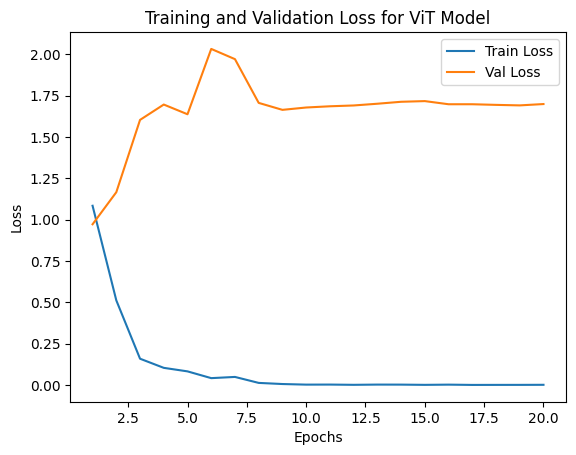

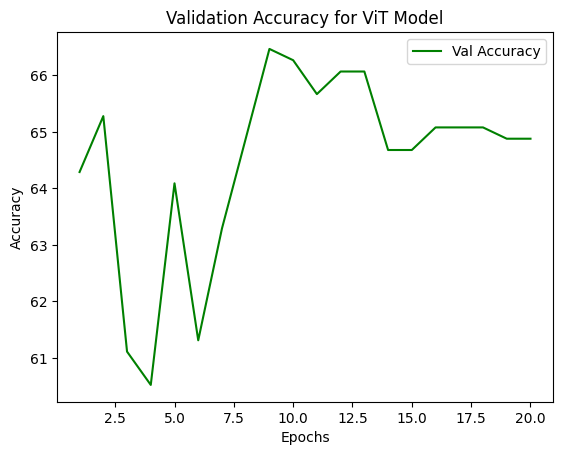

In [ ]:

# Data
epochs = list(range(1, 21))
train_loss = [
    1.0841, 0.5123, 0.1596, 0.1044, 0.0831,
    0.0422, 0.0495, 0.0134, 0.0066, 0.0030,
    0.0033, 0.0018, 0.0032, 0.0030, 0.0016,
    0.0029, 0.0012, 0.0014, 0.0015, 0.0019
]

val_loss = [
    0.9722, 1.1660, 1.6031, 1.6959, 1.6372,
    2.0321, 1.9703, 1.7059, 1.6638, 1.6780,
    1.6854, 1.6903, 1.7008, 1.7126, 1.7167,
    1.6977, 1.6977, 1.6939, 1.6908, 1.6989
]

val_accuracy = [
    64.29, 65.28, 61.11, 60.52, 64.09,
    61.31, 63.29, 64.88, 66.47, 66.27,
    65.67, 66.07, 66.07, 64.68, 64.68,
    65.08, 65.08, 65.08, 64.88, 64.88
]


# Plot the train and val loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for ViT Model')
plt.show()

# Plot the val accuracy
plt.plot(epochs, val_accuracy, label='Val Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for ViT Model')
plt.show()

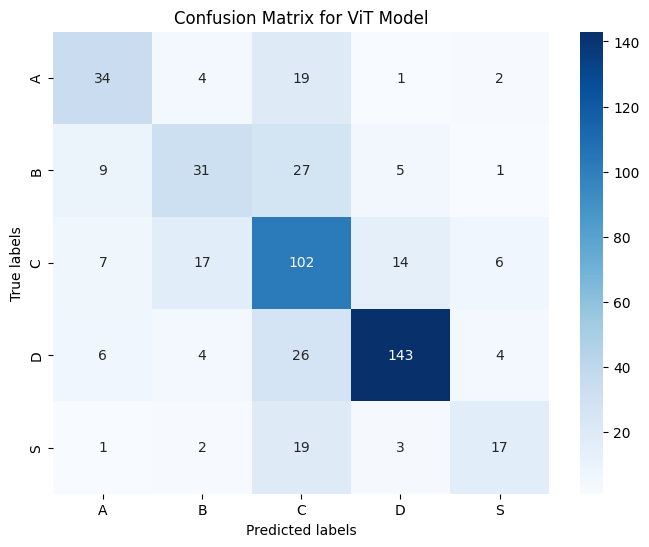

In [ ]:
# plot confusion matrix for ViT model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the data in the val_loader
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_train_dataset.classes, yticklabels=full_train_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for ViT Model')
plt.show()

In [ ]:
# Save the final model after all epochs
final_model_path = 'vit_model_final.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as '{final_model_path}'.")


Final model saved as 'vit_model_final.pth'.


In [ ]:
# ----------------------------
# 12. Inference on Unlabeled Test Data
# ----------------------------

class UnlabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # List all image files in the directory
        self.image_paths = [os.path.join(root, img) for img in os.listdir(root)
                            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Use 'L' for grayscale if needed
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and its path or any identifier

# Define transforms for test data (same as basic_transform)
test_transform = basic_transform

# Path to your test data
test_data_path = os.path.join(base_dir, 'Test_Data')

# Verify that the test data path exists
if not os.path.isdir(test_data_path):
    raise FileNotFoundError(f"Test data directory not found at {test_data_path}")

# Initialize the test dataset and loader
test_dataset = UnlabeledDataset(root=test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to perform inference on test data
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, img_paths in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(zip(img_paths, predicted.cpu().numpy()))

    return predictions

# Example of how to use the prediction function
# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)
model.eval()

# Perform predictions
test_predictions = predict(model, test_loader, device)

# Map predicted indices to class names
class_names = full_train_dataset.classes

# Save predictions to a CSV file
with open('test_predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Predicted Class'])
    for img_path, pred in test_predictions:
        writer.writerow([img_path, class_names[pred]])

print("Test predictions saved to 'test_predictions.csv'.")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test predictions saved to 'test_predictions.csv'.


VIT Large

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Aug 29 16:02:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             32W /   70W |    7104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os
from PIL import Image
import random

# ----------------------------
# 1. Device Configuration
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Data Augmentation and Normalization
# ----------------------------

# Basic transformations for all images
basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
                         std=[0.229, 0.224, 0.225]),
])

# Augmentation transformations to create additional samples
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
])

# ----------------------------
# 3. Load and Split the Dataset
# ----------------------------

# Path to your training data
train_data_path = os.path.join(base_dir, 'Train_Data')

# Verify that the training data path exists
if not os.path.isdir(train_data_path):
    raise FileNotFoundError(f"Training data directory not found at {train_data_path}")

# Load the full training dataset without any transformations initially
full_train_dataset = ImageFolder(root=train_data_path, transform=None)

# Extract labels for stratified splitting
labels = [label for _, label in full_train_dataset.samples]

# Define the split: 90% training and 10% validation
split_ratio = 0.1
num_classes = len(full_train_dataset.classes)

# Function to create balanced validation set
def create_balanced_val_set(full_dataset, num_classes, split_ratio):
    class_counts = get_class_counts(full_dataset)
    val_per_class = max(1, int(split_ratio * len(full_dataset) / num_classes))
    val_indices = []

    for cls in range(num_classes):
        class_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == cls]
        selected_indices = random.sample(class_indices, min(val_per_class, len(class_indices)))
        val_indices.extend(selected_indices)

    return val_indices

# Get indices for balanced validation set
val_indices = create_balanced_val_set(full_train_dataset, num_classes, split_ratio)

# Create training and validation subsets
train_indices = [i for i in range(len(full_train_dataset)) if i not in val_indices]
train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_train_dataset, val_indices)

# ----------------------------
# 4. Identify and Balance the Dataset
# ----------------------------

# Function to compute class counts
def get_class_counts(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Get class counts for the training subset
train_class_counts = get_class_counts(train_subset)
print("Class Counts in Training Set:", train_class_counts)

# Determine the maximum class count
max_count = max(train_class_counts.values())
print("Maximum class count:", max_count)

# Determine the number of samples to generate for each class
augmentation_counts = {cls: max_count - count for cls, count in train_class_counts.items()}
print("Number of Augmented Samples Needed per Class:", augmentation_counts)

# Custom BalancedDataset
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, augmentation_counts, augment_transform, basic_transform):
        self.original_dataset = original_dataset
        self.augmentation_counts = augmentation_counts
        self.augment_transform = augment_transform
        self.basic_transform = basic_transform

        self.class_to_indices = {}
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

        self.samples = []
        self.augmented_samples = []
        for label, count in augmentation_counts.items():
            original_indices = self.class_to_indices[label]
            self.samples.extend(original_indices)

            for _ in range(count):
                original_idx = random.choice(original_indices)
                self.augmented_samples.append(original_idx)

    def __len__(self):
        return len(self.samples) + len(self.augmented_samples)

    def __getitem__(self, idx):
        if idx < len(self.samples):
            original_idx = self.samples[idx]
            image, label = self.original_dataset[original_idx]
            image = self.basic_transform(image)
        else:
            aug_idx = self.augmented_samples[idx - len(self.samples)]
            image, label = self.original_dataset[aug_idx]
            image = self.augment_transform(image)
            image = self.basic_transform(image)

        return image, label

# Initialize the balanced dataset
balanced_train_dataset = BalancedDataset(
    original_dataset=train_subset,
    augmentation_counts=augmentation_counts,
    augment_transform=augment_transform,
    basic_transform=basic_transform
)

# ----------------------------
# 5. Prepare the Validation Dataset
# ----------------------------

# Define a new Dataset class to apply transforms to validation subset
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        image = self.transform(image)
        return image, label

# Apply basic_transform to validation dataset
balanced_val_dataset = SubsetWithTransform(val_subset, basic_transform)

# ----------------------------
# 6. Create DataLoaders
# ----------------------------

# Define DataLoaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(balanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# ----------------------------
# 7. Model Setup with Transfer Learning (ViT)
# ----------------------------

# Number of classes
num_classes = 5

# Initialize the pre-trained ViT model
#model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Replace the classification head and increase dropout
model.head = nn.Sequential(
    nn.Dropout(p=0.5),  # Increased dropout
    nn.Linear(model.head.in_features, num_classes)
)

# Move the model to the appropriate device
model = model.to(device)

# ----------------------------
# 8. Loss Function and Optimizer
# ----------------------------

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)  # Adjust weight_decay for L2 regularization

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ----------------------------
# 9. Training and Validation Functions
# ----------------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_accuracy = 0.0
    best_model_path = 'best_vit_model.pth'

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

        # Step the scheduler
        scheduler.step()

        # Save the model if it has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)

    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
    return best_model_path

# ----------------------------
# 10. Run Training
# ----------------------------

best_model_path = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)


Using device: cuda
Class Counts in Training Set: {0: 249, 1: 312, 2: 681, 3: 864, 4: 160}
Maximum class count: 864
Number of Augmented Samples Needed per Class: {0: 615, 1: 552, 2: 183, 3: 0, 4: 704}
Epoch [1/20], Train Loss: 0.6177, Val Loss: 0.5060, Val Accuracy: 84.40%, Time: 146.04s
Epoch [2/20], Train Loss: 0.1768, Val Loss: 0.4885, Val Accuracy: 85.60%, Time: 145.71s
Epoch [3/20], Train Loss: 0.0998, Val Loss: 0.6192, Val Accuracy: 85.20%, Time: 145.84s
Epoch [4/20], Train Loss: 0.0940, Val Loss: 0.6078, Val Accuracy: 85.20%, Time: 144.85s
Epoch [5/20], Train Loss: 0.0608, Val Loss: 0.7186, Val Accuracy: 84.00%, Time: 146.03s
Epoch [6/20], Train Loss: 0.0514, Val Loss: 0.8629, Val Accuracy: 85.20%, Time: 145.89s
Epoch [7/20], Train Loss: 0.0728, Val Loss: 0.9628, Val Accuracy: 80.00%, Time: 145.15s
Epoch [8/20], Train Loss: 0.0249, Val Loss: 0.7335, Val Accuracy: 82.80%, Time: 146.05s
Epoch [9/20], Train Loss: 0.0116, Val Loss: 0.7666, Val Accuracy: 84.00%, Time: 144.85s
Epoch [1

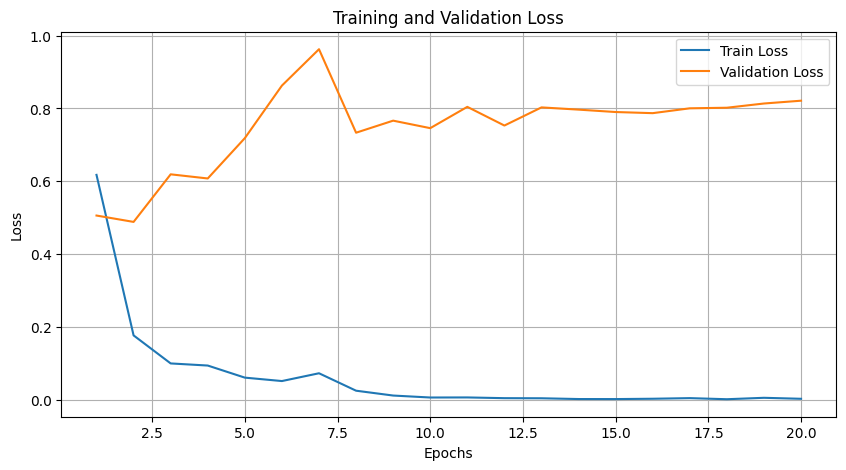

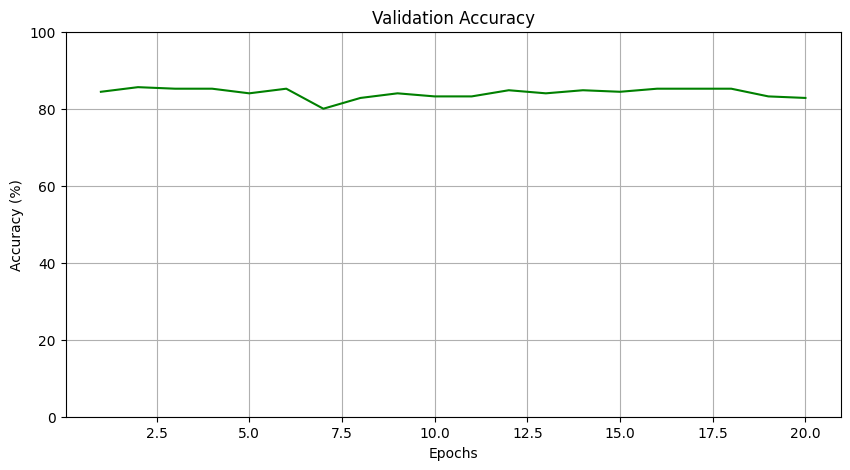

In [4]:
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define the data
# -----------------------------
train_loss = [
    0.6177, 0.1768, 0.0998, 0.0940, 0.0608, 0.0514, 0.0728, 0.0249, 0.0116, 0.0062,
    0.0064, 0.0044, 0.0041, 0.0020, 0.0019, 0.0028, 0.0045, 0.0015, 0.0054, 0.0027
]

val_loss = [
    0.5060, 0.4885, 0.6192, 0.6078, 0.7186, 0.8629, 0.9628, 0.7335, 0.7666, 0.7460,
    0.8045, 0.7532, 0.8030, 0.7969, 0.7903, 0.7872, 0.8005, 0.8021, 0.8137, 0.8214
]

val_accuracy = [
    84.40, 85.60, 85.20, 85.20, 84.00, 85.20, 80.00, 82.80, 84.00, 83.20,
    83.20, 84.80, 84.00, 84.80, 84.40, 85.20, 85.20, 85.20, 83.20, 82.80
]

epochs = range(1, 21)

# -----------------------------
# 2. Plot Train Loss vs Val Loss
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 3. Plot Validation Accuracy
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.ylim(0, 100)
plt.grid(True)
plt.show()


In [ ]:
# ----------------------------
# 12. Inference on Unlabeled Test Data
# ----------------------------

class UnlabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # List all image files in the directory
        self.image_paths = [os.path.join(root, img) for img in os.listdir(root)
                            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Use 'L' for grayscale if needed
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and its path or any identifier

# Define transforms for test data (same as basic_transform)
test_transform = basic_transform

# Path to your test data
test_data_path = os.path.join(base_dir, 'Test_Data')

# Verify that the test data path exists
if not os.path.isdir(test_data_path):
    raise FileNotFoundError(f"Test data directory not found at {test_data_path}")

# Initialize the test dataset and loader
test_dataset = UnlabeledDataset(root=test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to perform inference on test data
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, img_paths in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(zip(img_paths, predicted.cpu().numpy()))

    return predictions

# Example of how to use the prediction function
# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)
model.eval()

# Perform predictions
test_predictions = predict(model, test_loader, device)

# Map predicted indices to class names
class_names = full_train_dataset.classes

# Save predictions to a CSV file
with open('test_predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Predicted Class'])
    for img_path, pred in test_predictions:
        writer.writerow([img_path, class_names[pred]])

print("Test predictions saved to 'test_predictions.csv'.")


Test predictions saved to 'test_predictions.csv'.


In [ ]:

# Load the predictions
import pandas as pd
df = pd.read_csv('test_predictions.csv')

# remove the jpg extension from the Image Path column and sort by ID also remove the path
df['ID'] = df['Image Path'].str.replace('.jpg', '').str.split('/').str[-1].astype(int)
df = df[['ID', 'Predicted Class']]
df = df.sort_values('ID')
# change the column name to Predictions and map the class names to integers 1-5
df.columns = ['ID', 'Predictions']
df['Predictions'] = df['Predictions'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5})


# now save the sorted predictions
df.to_csv('test_predictions2.csv', index=False)
print("Predictions sorted and saved to 'test_predictions2.csv'")

Predictions sorted and saved to 'test_predictions2.csv'


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


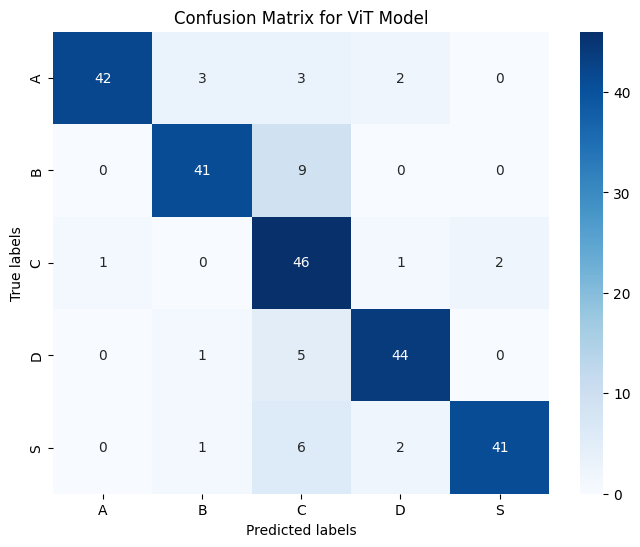

In [ ]:
# plot confusion matrix for ViT model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the data in the val_loader
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_train_dataset.classes, yticklabels=full_train_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for ViT Model')
plt.show()

#ResNet

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Aug 29 17:02:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             30W /   70W |    8500MiB /  15360MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
import os
from PIL import Image
import random
import csv
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

# ----------------------------
# 1. Device Configuration
# ----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Data Augmentation and Normalization
# ----------------------------

# Basic transformations for all images
basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
                         std=[0.229, 0.224, 0.225]),
])

# Augmentation transformations to create additional samples
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
])

# ----------------------------
# 3. Load and Split the Dataset
# ----------------------------

# Paths
# ----------------------------
base_dir = Path("/content/drive/MyDrive/Project2/Project 1 Data")
train_data_path = os.path.join(base_dir, 'Train_Data')


# Verify that the training data path exists
if not os.path.isdir(train_data_path):
    raise FileNotFoundError(f"Training data directory not found at {train_data_path}")

# Load the full training dataset without any transformations initially
full_train_dataset = ImageFolder(root=train_data_path, transform=None)

# Extract labels for stratified splitting
labels = [label for _, label in full_train_dataset.samples]

# Define the split: 80% training and 20% validation
split_ratio = 0.2
split = StratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=42)
train_idx, val_idx = next(split.split(np.zeros(len(labels)), labels))

# Create training and validation subsets
train_subset = Subset(full_train_dataset, train_idx)
val_subset = Subset(full_train_dataset, val_idx)

# ----------------------------
# 4. Identify and Balance the Dataset
# ----------------------------

# Function to compute class counts
def get_class_counts(dataset):
    class_counts = {}
    for _, label in dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Get class counts for the training subset
train_class_counts = get_class_counts(train_subset)
print("Class Counts in Training Set:", train_class_counts)

# Determine the maximum class count
max_count = max(train_class_counts.values())
print("Maximum class count:", max_count)

# Determine the number of samples to generate for each class
augmentation_counts = {cls: max_count - count for cls, count in train_class_counts.items()}
print("Number of Augmented Samples Needed per Class:", augmentation_counts)

# Custom BalancedDataset
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, augmentation_counts, augment_transform, basic_transform):
        """
        original_dataset: Subset of ImageFolder
        augmentation_counts: dict mapping class index to number of samples to augment
        augment_transform: Transformations to apply for augmentation
        basic_transform: Basic transformations to apply to all images
        """
        self.original_dataset = original_dataset
        self.augmentation_counts = augmentation_counts
        self.augment_transform = augment_transform
        self.basic_transform = basic_transform

        # Organize indices by class
        self.class_to_indices = {}
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

        # Prepare lists of original and augmented samples
        self.samples = []
        self.augmented_samples = []
        for label, count in augmentation_counts.items():
            original_indices = self.class_to_indices[label]
            self.samples.extend(original_indices)  # Original samples

            # Generate augmented samples
            for _ in range(count):
                original_idx = random.choice(original_indices)
                self.augmented_samples.append(original_idx)  # Placeholder for augmented samples

    def __len__(self):
        return len(self.samples) + len(self.augmented_samples)

    def __getitem__(self, idx):
        if idx < len(self.samples):
            original_idx = self.samples[idx]
            image, label = self.original_dataset[original_idx]
            image = self.basic_transform(image)
        else:
            aug_idx = self.augmented_samples[idx - len(self.samples)]
            image, label = self.original_dataset[aug_idx]
            image = self.augment_transform(image)
            image = self.basic_transform(image)

        # Debugging: Ensure image is a tensor
        if not isinstance(image, torch.Tensor):
            raise TypeError(f"Transformed image is not a tensor. Type: {type(image)} at index {idx}")

        return image, label

# Initialize the balanced dataset
balanced_train_dataset = BalancedDataset(
    original_dataset=train_subset,
    augmentation_counts=augmentation_counts,
    augment_transform=augment_transform,
    basic_transform=basic_transform
)

# Verify the new class counts
def verify_balanced(dataset, num_classes):
    class_counts = {cls:0 for cls in range(num_classes)}
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

balanced_train_class_counts = verify_balanced(balanced_train_dataset, len(full_train_dataset.classes))
print("Class Counts in Balanced Training Set:", balanced_train_class_counts)

# ----------------------------
# 5. Prepare the Validation Dataset
# ----------------------------

# Define a new Dataset class to apply transforms to validation subset
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        image = self.transform(image)
        return image, label

# Apply basic_transform to validation dataset
balanced_val_dataset = SubsetWithTransform(val_subset, basic_transform)

# ----------------------------
# 6. Create DataLoaders
# ----------------------------

# Define DataLoaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(balanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# ----------------------------
# 7. Model Setup with Transfer Learning (ViT)
# ----------------------------

# Number of classes
num_classes = 5

# Initialize the pre-trained Resnet model

model = timm.create_model('resnet50', pretrained=True)

# Replace the classification head for ResNet
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Move the model to the appropriate device
model = model.to(device)

# ----------------------------
# 8. Loss Function and Optimizer
# ----------------------------

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ----------------------------
# 9. Training and Validation Functions
# ----------------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_accuracy = 0.0
    best_res_net_model_path = 'best_res_net_model.pth'

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%, "
              f"Time: {epoch_time:.2f}s")

        # Step the scheduler
        scheduler.step()

        # Save the model if it has the best accuracy so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_res_net_model_path)
            print(f"Best model saved with Val Accuracy: {best_val_accuracy:.2f}%")

    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.2f}%")
    print(f"Best model saved as '{best_res_net_model_path}'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Class Counts in Training Set: {4: 168, 3: 731, 1: 289, 0: 239, 2: 585}
Maximum class count: 731
Number of Augmented Samples Needed per Class: {4: 563, 3: 0, 1: 442, 0: 492, 2: 146}
Class Counts in Balanced Training Set: {0: 731, 1: 731, 2: 731, 3: 731, 4: 731}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch [1/20], Train Loss: 1.5954, Val Loss: 1.5795, Val Accuracy: 32.94%, Time: 44.06s
Best model saved with Val Accuracy: 32.94%
Epoch [2/20], Train Loss: 1.5608, Val Loss: 1.5394, Val Accuracy: 42.06%, Time: 44.65s
Best model saved with Val Accuracy: 42.06%
Epoch [3/20], Train Loss: 1.5070, Val Loss: 1.4881, Val Accuracy: 45.44%, Time: 45.07s
Best model saved with Val Accuracy: 45.44%
Epoch [4/20], Train Loss: 1.4165, Val Loss: 1.3762, Val Accuracy: 45.83%, Time: 44.86s
Best model saved with Val Accuracy: 45.83%
Epoch [5/20], Train Loss: 1.2967, Val Loss: 1.2753, Val Accuracy: 48.81%, Time: 46.66s
Best model saved with Val Accuracy: 48.81%
Epoch [6/20], Train Loss: 1.1810, Val Loss: 1.2062, Val Accuracy: 52.18%, Time: 44.96s
Best model saved with Val Accuracy: 52.18%
Epoch [7/20], Train Loss: 1.0814, Val Loss: 1.1426, Val Accuracy: 53.57%, Time: 44.86s
Best model saved with Val Accuracy: 53.57%
Epoch [8/20], Train Loss: 1.0243, Val Loss: 1.1336, Val Accuracy: 53.97%, Time: 44.47s
Bes

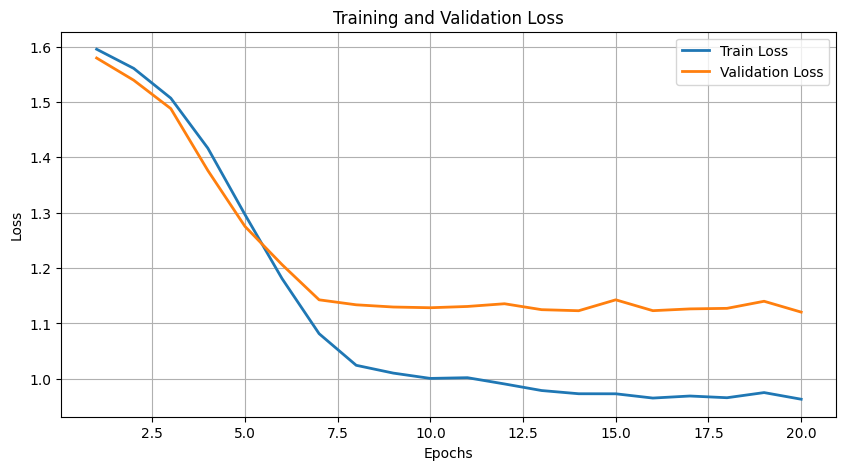

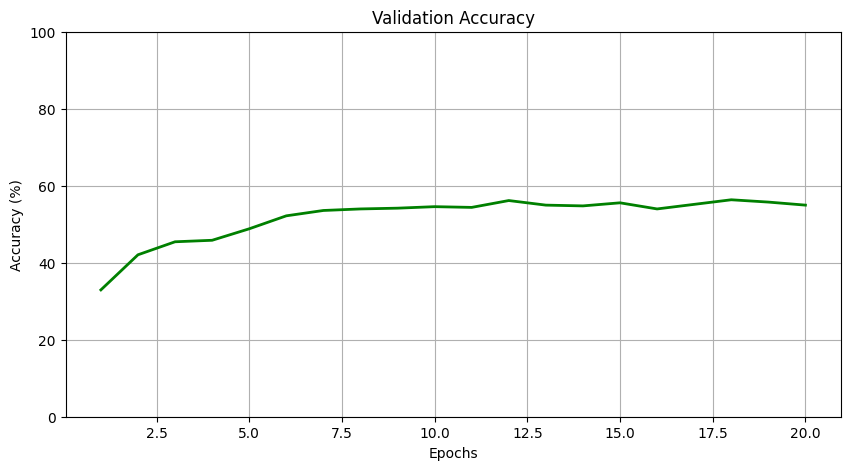

In [5]:
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define the data from your logs
# -----------------------------
train_loss = [
    1.5954, 1.5608, 1.5070, 1.4165, 1.2967, 1.1810, 1.0814, 1.0243, 1.0102, 1.0006,
    1.0019, 0.9906, 0.9787, 0.9729, 0.9728, 0.9651, 0.9688, 0.9657, 0.9750, 0.9630
]

val_loss = [
    1.5795, 1.5394, 1.4881, 1.3762, 1.2753, 1.2062, 1.1426, 1.1336, 1.1296, 1.1283,
    1.1306, 1.1355, 1.1248, 1.1229, 1.1426, 1.1230, 1.1262, 1.1272, 1.1400, 1.1204
]

val_accuracy = [
    32.94, 42.06, 45.44, 45.83, 48.81, 52.18, 53.57, 53.97, 54.17, 54.56,
    54.37, 56.15, 54.96, 54.76, 55.56, 53.97, 55.16, 56.35, 55.75, 54.96
]

epochs = range(1, 21)

# -----------------------------
# 2. Plot Train Loss vs Val Loss
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 3. Plot Validation Accuracy
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.ylim(0, 100)
plt.grid(True)
plt.show()
